## Imports

In [1]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A

# PIL for image operations
from PIL import Image

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# TensorBoardX - TensorBoard for PyTorch
from tensorboardX import SummaryWriter

# CodeCarbon for tracking our carbon emissions
from codecarbon import EmissionsTracker

# tqdm for showing progress bars
from tqdm.notebook import tqdm

import os

## Visualize Dimensions of Images in Classes
This helps us with:
- Understanding our data
- Choosing a fixed image size

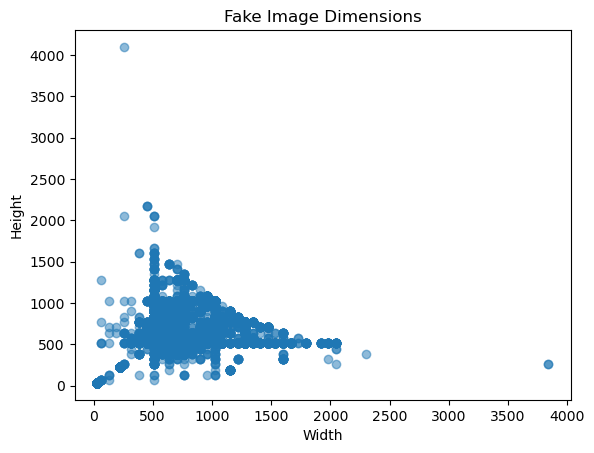

In [3]:
# Plotting dimensions of ai-generated images

img_dir = "/Users/jacob/OneDrive/Desktop/image-dataset/dataset_1/Fake"

# Getting all images in the directory that contains ai-generated faces
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('jpeg', 'jpg', 'png', 'webp'))]

widths = []
heights = []

# Loop through each image and extract its dimensions
for img_file in img_files:
    with Image.open(os.path.join(img_dir, img_file)) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Plot the dimensions of the images in a scatter plot
plt.scatter(widths, heights, alpha=0.5)
plt.title('Fake Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

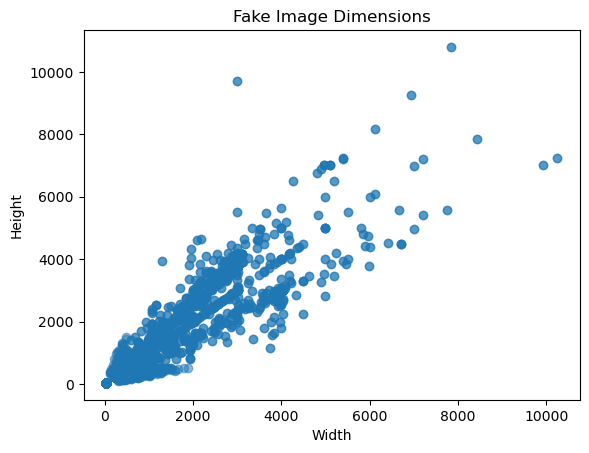

In [5]:
# Plotting dimensions of ai-generated images

img_dir = "/Users/jacob/OneDrive/Desktop/image-dataset/dataset_1/Real"

# Getting all images in the directory that contains ai-generated faces
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('jpeg', 'jpg', 'png', 'webp'))]

widths = []
heights = []

# Loop through each image and extract its dimensions
for img_file in img_files:
    with Image.open(os.path.join(img_dir, img_file)) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Plot the dimensions of the images in a scatter plot
plt.scatter(widths, heights, alpha=0.5)
plt.title('Fake Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

## Setup Neural Network Architecture
We will reuse the architecture from our face detection model. This architecture includes convolutional layers with residual blocks, followed by fully connected layers for classification.
This is essential, because we want to utilize transfer learning with our trained face detection model 

In [6]:
class ResBlock(nn.Module):
    """
    A residual block that consists of a convolutional block and a skip connection.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(ResBlock, self).__init__()
        
        # Define main convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # Define skip connection and adapt channels as if needed
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    # Pass input through main block and add skip connection
    def forward(self, x):
        out = self.block(x)
        res = self.residual(x)
        return out + res

class AdjustedResCNN(nn.Module):
    """
    This is an adjusted version of our DeeperDNN with slight adjustments and the addition of skip connections.
    This is the model architecture of our currently deployed face detection model.
    """
    def __init__(self, dropout_prob=0.3):
        super(AdjustedResCNN, self).__init__()

        # Convolutional layers with residual blocks and max-pooling. The dropout probability is reduced for the convolutional layers
        self.conv_layers = nn.Sequential(
            ResBlock(3, 24, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(24, 48, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(48, 96, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(96, 192, dropout_prob * 0.2),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 448),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(448, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 112),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(112, 1) # Final layer with one output for our binary classification problem
        )

    def feature_size(self):
        """
        Compute size of flattend features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers
        """
        return self.conv_layers(torch.zeros(1, 3, 256, 256)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

## Set Up Device Agnostic Code

In [ ]:
# Set the device to GPU if available, else use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

## Hyperparameters

In [7]:
# Define Hyperparameters
num_classes = 2
learning_rate = 0.001
batch_size = 16
num_epochs = 12